# 2. Classify Manhattan with Single Neuron on TensorFlow

In this codelab, we will use TensorFlow to train a single neuron to predict whether a geolocation is in Manhattan or not, by looking at its longitude and latitude.

![](images/manhattan.png)

## 2-1. Importing the training data from BigQuery

At first, we will get a training data from the public dataset on BigQuery. One of the [NYPD Motor Vehicle Collisions Data](https://cloud.google.com/bigquery/public-data/nypd-mv-collisions) which collects all the car accidents happened in NYC from 2012 to the present. 

Let's take a look at the data by executing a BigQuery SQL. In Cloud Datalab, you can execute it by using "%%sql" command (see [this doc](https://github.com/googledatalab/notebooks/tree/master/tutorials/BigQuery) to learn more about the BigQuery commands). **Select the cell below and run the query** by clicking "Run" on the menu.

In [1]:
%%sql -d standard
SELECT
  timestamp,
  borough,
  latitude,
  longitude
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
ORDER BY
  timestamp DESC
LIMIT
  15

timestamp,borough,latitude,longitude
2017-02-21 23:55:00,BRONX,40.883343,-73.8499
2017-02-21 23:47:00,,,
2017-02-21 23:41:00,BROOKLYN,,
2017-02-21 22:58:00,,,
2017-02-21 22:35:00,,,
2017-02-21 22:15:00,BROOKLYN,40.65136,-73.86971
2017-02-21 22:07:00,BROOKLYN,40.676952,-73.888596
2017-02-21 22:03:00,BROOKLYN,40.63593,-74.007195
2017-02-21 21:50:00,,40.803627,-73.963394
2017-02-21 21:50:00,BROOKLYN,40.626545,-73.94101


### Preprocess the training data on BigQuery

In this codelab, we do not care about the car accidents. We just wanted to use the data for getting pairs of "latitude", "longitude" and "Is it Manhattan or not". So, we want to do the following preprocessing on this raw data:

- Add a column "is_mt" that returns 1 or 0 to indicate if the borough is Manhattan or not
- Remove rows without borough info
- Remove rows without longitude/latitude info
- Remove rows for Bronx (as it's too close to Manhattan and hard to classify with single neuron!)
- Randomly shuffule all the rows (for making the training data even)
- Select only the 10,000 rows

So, our SQL with the preprocessing will look like the following. **Select the cell below and run it**. Please note that this only defines the SQL module "nyc_collisions" that will be used later and does not output anything.

In [2]:
%%sql --module nyc_collisions
SELECT
  IF(borough = 'MANHATTAN', 1, 0) AS is_mt,
  latitude,
  longitude
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  LENGTH(borough) > 0
  AND latitude IS NOT NULL AND latitude != 0.0
  AND longitude IS NOT NULL AND longitude != 0.0
  AND borough != 'BRONX'
ORDER BY
  RAND()
LIMIT
  10000

### Import the BigQuery SQL result as NumPy array

Then, we need to execute the SQL defined above and import the data into Datalab. For this purpose, Datalab provides [BigQuery APIs](https://github.com/googledatalab/notebooks/blob/master/tutorials/BigQuery/BigQuery%20APIs.ipynb) that allows you to execute the define SQL and import the results as a [NumPy](http://www.numpy.org/) array named `nyc_cols`. **Run the cell below** and confirm it loaded 10,000 rows.

In [3]:
import datalab.bigquery as bq
nyc_cols = bq.Query(nyc_collisions).to_dataframe(dialect='standard').as_matrix()
print nyc_cols
print "\nLoaded " + str(len(nyc_cols)) + " rows."

[[  0.         40.6525571 -73.9604221]
 [  1.         40.7584357 -73.9789126]
 [  0.         40.6919621 -73.7972118]
 ..., 
 [  0.         40.6560853 -74.0058422]
 [  0.         40.6684505 -73.9935295]
 [  0.         40.5490216 -74.2233397]]

Loaded 10000 rows.


Let's take a look at what's inside the result. **Run the cell below** and check the variable `is_mt` has an array of 1s and 0s representing each geolocation is in Manhattan or not, and the variable `latlng` has an array of pairs of latitude and longitude.

In [4]:
import numpy as np
is_mt = nyc_cols[:,0].astype(np.int32) # read the 0th column (is_mt) as int32
latlng = nyc_cols[:,1:3].astype(np.float32) # read the 1st and 2nd column (latitude and longitude) as float32
print "Is Manhattan: " + str(is_mt)
print "\nLat/Lng: \n\n" + str(latlng)

Is Manhattan: [0 1 0 ..., 0 0 0]

Lat/Lng: 

[[ 40.65255737 -73.9604187 ]
 [ 40.7584343  -73.97891235]
 [ 40.6919632  -73.79721069]
 ..., 
 [ 40.65608597 -74.00584412]
 [ 40.6684494  -73.99353027]
 [ 40.54902267 -74.2233429 ]]


### What is NumPy?

You might notice that we just used NumPy for extracting the results. NumPy is the most popular Python library for numerical calculations. For machine learning with Python, many people are using NumPy for wide variety of numerical operations, including the basic array operations such as reshaping, merging, splitting, filtering, slicing and indexing. Many of TensorFlow APIs are also influenced by NumPy and use similar concepts. If you want to learn machine learning and TensorFlow with Python, we recommend you to learn [the basics of NumPy](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html).

## 2-2. Feature scaling and splitting data

Now we got the training data. But it's not ready for training a neural network model yet. If you use the raw data directly, you would fail on the training because the scales of each feature (latitude and longitude in this case) are quite different. 

In machine learning, usually you need to preprocess the raw data with [Feature scaling](https://en.wikipedia.org/wiki/Feature_scaling) to normalize the feature data to have the same scale so that it can make it easier for machine learning algorithms to train the model.

In this codelab, we will use [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) of [scikit-learn](http://scikit-learn.org/stable/index.html), the another popular library for machine learning in Python. The MinMaxScaler scales the features based on their minimum and maximum values to fit everything into 0 to 1. **Run the cell below** and see how it scales the latitudes and longitudes and stores them into a variable `latlng_std`.

In [5]:
from sklearn.preprocessing import MinMaxScaler
latlng_std = MinMaxScaler().fit_transform(latlng)
latlng_std

array([[ 0.41118622,  0.52952576],
       [ 0.69459534,  0.49588013],
       [ 0.51667023,  0.8263855 ],
       ..., 
       [ 0.42063141,  0.44689941],
       [ 0.45372772,  0.46929932],
       [ 0.13404846,  0.05128479]], dtype=float32)

### Plot the training data with Matplotlib

Now, all the preprocessing on the training data have finished. Let's see how it looks like by using [Matplotlib](http://matplotlib.org/), the popular visualization library for Python. **Run the cell below** and see the plot.

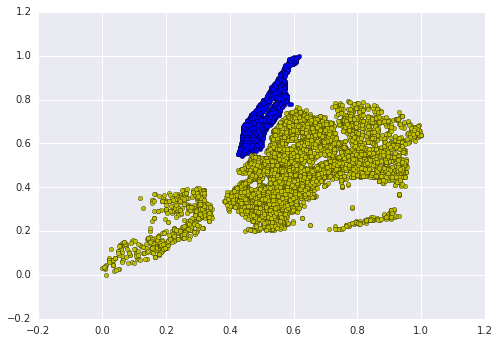

In [6]:
import matplotlib.pyplot as plt
lat = latlng_std[:,0]
lng = latlng_std[:,1]
plt.scatter(lng[is_mt == 1], lat[is_mt == 1], c='b')
plt.scatter(lng[is_mt == 0], lat[is_mt == 0], c='y')
plt.show()

You can see that the geolocations in Manhattan are plotted in blue dots, and others are in yellow dots. Also, latitudes and longitudes are scaled from 0 to 1.

### Split the data into "Training Data" and "Test Data"

Before start training the neural network model, we need to separate a part of the training data as test data. The test data will be used for checking accuracy of classifications by the model after the training. This is a common practice in machine learning to accurately evaluate the performance of your training model.

**Run the cell below** and split the data into 8,000 pairs of training data and 2,000 pairs of test data.

In [7]:
# 8,000 pairs for training
latlng_train = latlng_std[0:7999]
is_mt_train = is_mt[0:7999]

# 2,000 pairs for test
latlng_test = latlng_std[8000:9999]
is_mt_test = is_mt[8000:9999]

print "Split finished."

Split finished.


## 2-3. Train the Neural Network with TensorFlow High-level API

<br/>
![](images/tflogo.png)
<br/>

Now, let's use [TensorFlow](https://www.tensorflow.org/).

TensorFlow is an open source library for machine learning. You can define your own neural network or deep learning model and run a training for it on your laptop, or on [many CPUs and GPUs in the cloud](https://cloud.google.com/ml/) for scalable and faster training and prediction.

TensorFlow provides two kind of APIs:

- [High level API](https://www.tensorflow.org/get_started/tflearn): provides easy-to-use [predefined machine learning models](https://www.tensorflow.org/api_guides/python/contrib.learn#estimators)
- [Low level API](https://www.tensorflow.org/get_started/get_started): provides customizable data flow computation framework for machine learning

If you will use common neural network and machine learning models (such as fully-connected neural network, convolutional neural network, logistic regression and k-means), the high level API is recommended. If you want to design your own neural network model with sophisticated or new algorithm, or if you like to learn the underlying technology used for implementing the high level API, you may want to use the low level API.

In this codelab, we will use the high level API first, and then look at the low level API to learn more about the underlying technology.

### Define a single layer neural network

**Run the cell below** to define a neural network.

In [13]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR) # supress warning messages

# define two feature columns with real values
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=2)]

# create a neural network
dnnc = tf.contrib.learn.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[],
  n_classes=3) # need specify 3 instead of 2 (maybe bug?)

dnnc

The code above does the following:

- At line 2, setting the log level to ERROR to supress warning messages
- At line 5, defining "feature columns" (columns in the training data used for training the model) as two dimensional real values
- At line 8, defining a neural network by using [DNNClassifier](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/DNNClassifier) class with the following parameters:
 - No hidden units (= fully connected single layer neural network)
 - Use two classes for classification (Manhattan or not)
 
In a nutshell, this code defines a neural network like this, which is the same single neuron we tried with the Playground, where we put latitude and longitude as input to x1 and x2 respectively.

![](https://camo.githubusercontent.com/5e5ec313899c2a799884120e3ca7e35048bff600/68747470733a2f2f636c6f75642e676f6f676c652e636f6d2f626c6f672f6269672d646174612f323031362f30372f696d616765732f3134363739383934343137383233382f6e657572616c2d6e6574776f726b732d31332e706e67)
![](https://camo.githubusercontent.com/e522363969e3770e515208b84dc092738bf53d45/68747470733a2f2f636c6f75642e676f6f676c652e636f6d2f626c6f672f6269672d646174612f323031362f30372f696d616765732f3134363739383934343137383233382f6e657572616c2d6e6574776f726b732d31352e706e67)

Just like we saw the neuron was able to classify the two groups of data points, this time we will train the neuron for classifying whether a geolocation is in Manhattan or not.

### Check the accuracy of the neural network

Before start training the neural network, let's define two methods for checking the accuracy of the neural network. **Run the cell below**.

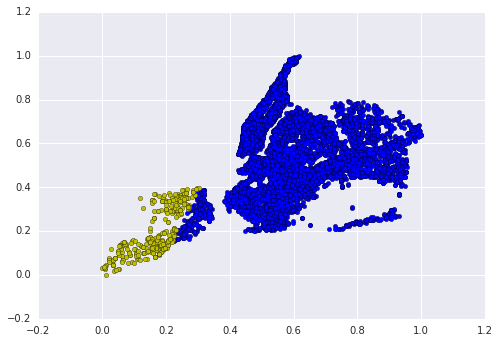

Accuracy: 32.77%


In [14]:
# plot a predicted map of Manhattan
def plot_predicted_map():
  is_mt_pred = dnnc.predict(latlng_std) # an array of prediction results
  plt.scatter(lng[is_mt_pred == 1], lat[is_mt_pred == 1], c='b')
  plt.scatter(lng[is_mt_pred == 0], lat[is_mt_pred == 0], c='y')
  plt.show()

# print the accuracy of the neural network 
def print_accuracy():
  accuracy = dnnc.evaluate(x=latlng_test, y=is_mt_test)["accuracy"]
  print('Accuracy: {:.2%}'.format(accuracy))
  
# train the model just for 1 step and print the accuracy
dnnc.fit(x=latlng_train, y=is_mt_train, steps=1)
plot_predicted_map()
print_accuracy()

In the first method `plot_predicted_map()` at line 3, it calls [predict()](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/DNNClassifier#predict) method of `DNNClassifier` class to get an array of prediction results (10,000 rows) like `[1 0 0 1 ... 0 0 1 0]` where `1` means that the neural network believes the geolocation is in Manhattan, and `0` means it's not. By using this array as index for selecting `lat` and `lng`, the method plots geolocations predicted as Manhattan in blue dots and others in yellow dots.

In the second method `print_accuracy()` at line 9, it calls [evaluate()](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/Evaluable#evaluate) method of `DNNClassifier` class to calculate the accuracy of the prediction and print it.

After defining the two methods, it calls [fit()](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/Trainable#fit) method of `DNNClassifier` class at line 14 to train the model for just one step. A step in the `fit()` method moves the weights and bias in the neural network only for a little towards the direction of reducing the error. Usually it takes thousands of steps to finish training the neural network. So, at line 14 - 16, you see how the neural network in the initial state gives so low accuracy and can not color the Manhattan on the map properly. 

### Train the neural network

Finally let's start training the neural network. This time, we will train it with 5000 steps. At every 500 steps, it will call `plot_predicted_map()` and `print_accuracy()` to show the current accuracy of the network. **Run the cell below** and wait for a couple of minutes until the message "Finished" is printed. You will see the network is trying to **move the weights and bias slowly** to minimize the error and find the best position of the line for classifying geolocations in Manhattan. The final accuracy would be as high as 95%.

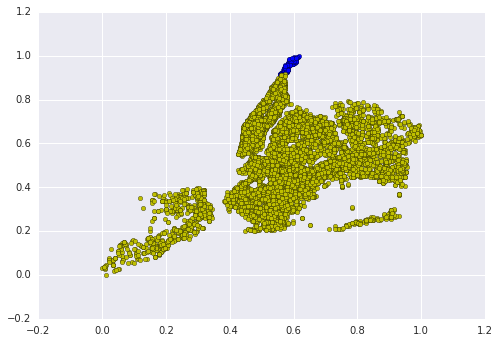

Steps: 500
Accuracy: 72.69%


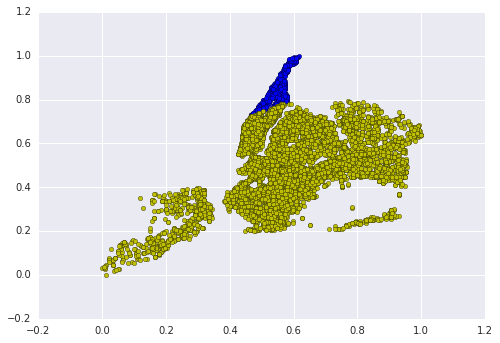

Steps: 1000
Accuracy: 78.99%


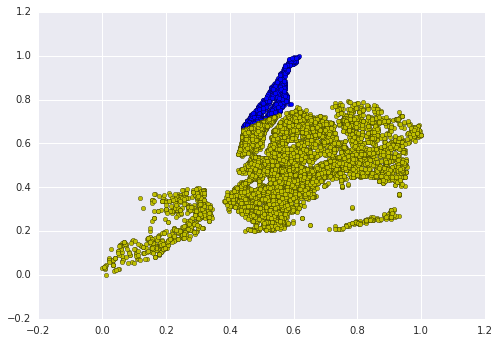

Steps: 1500
Accuracy: 85.94%


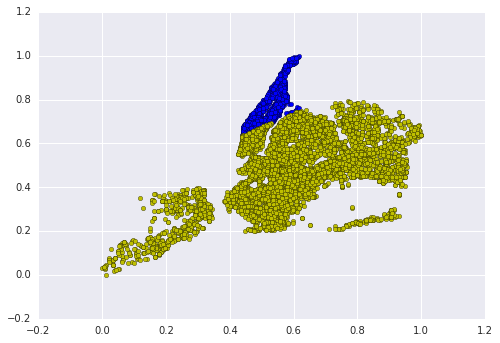

Steps: 2000
Accuracy: 90.75%


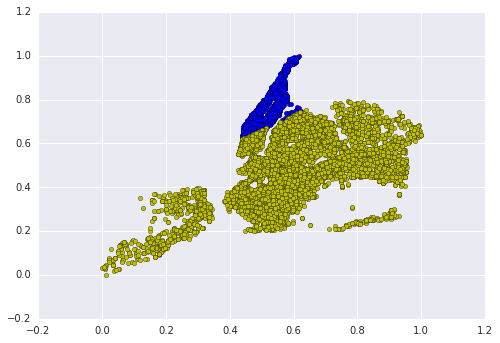

Steps: 2500
Accuracy: 92.60%


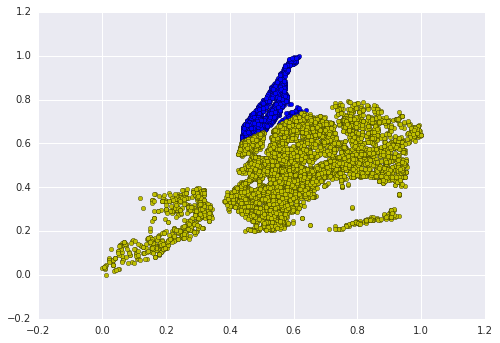

Steps: 3000
Accuracy: 93.35%


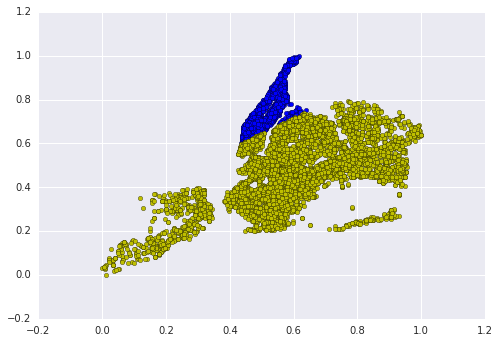

Steps: 3500
Accuracy: 94.10%


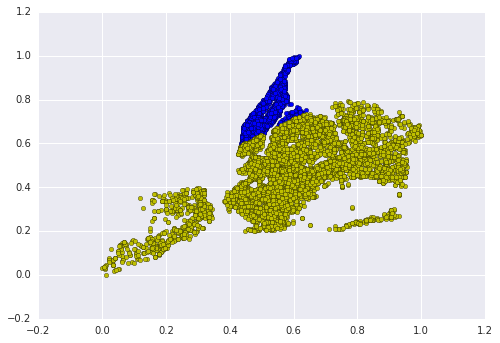

Steps: 4000
Accuracy: 94.40%


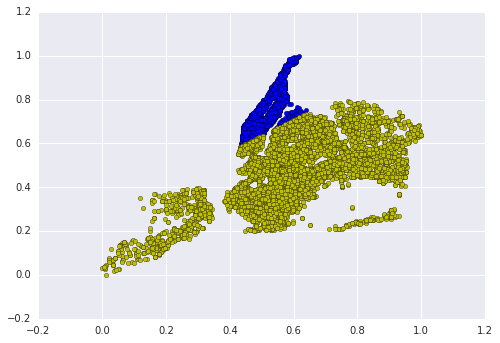

Steps: 4500
Accuracy: 94.70%


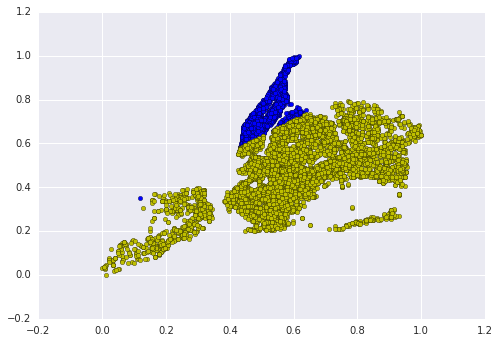

Steps: 5000
Accuracy: 94.90%

Training Finished.


In [15]:
steps = 500
for i in range (1, 11):
  dnnc.fit(x=latlng_train, y=is_mt_train, steps=steps)
  plot_predicted_map()
  print 'Steps: ' + str(i * steps)
  print_accuracy()
  
print('\nTraining Finished.')

## Lab: Observations